## Protein Embeddings Manipulation

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt

from protera_stability import EmbeddingExtractor1D, AttrDict, load_dataset_raw

### Get Dataset

In [2]:
data_path = Path("../data")
X, y = load_dataset_raw(data_path, kind="train", scale=True)

Using cache found in /home/roberto/.cache/torch/hub/facebookresearch_esm_master
Returning existing dataset...


In [3]:
X.mean(), X.var(), X.shape

(-8.3492886e-11, 1.0000006, (7710, 1280))

In [4]:
y.mean(), y.var()

(-3.9581813e-09, 1.0)

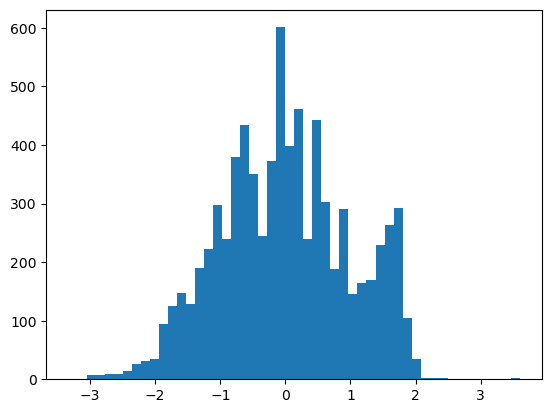

In [5]:
plt.hist(y, bins=50)
plt.show()

## Dimensionality Reduction

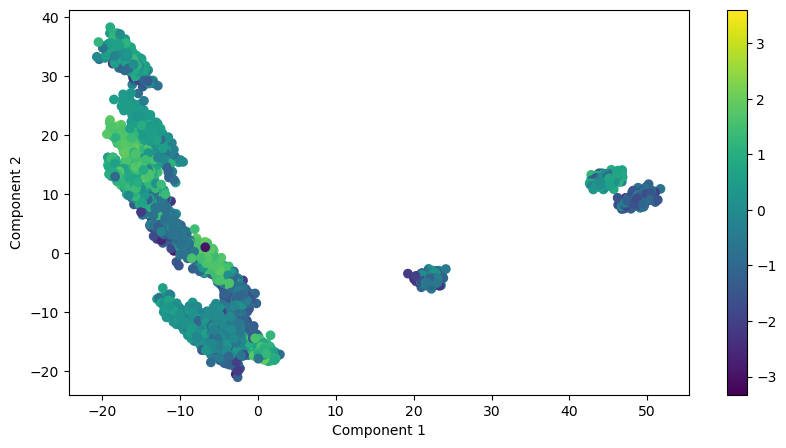

In [6]:
from protera_stability import dim_reduction

X = dim_reduction(X, y, n_components=32, plot_viz=True)

In [8]:
from protera_stability import perform_search

from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=123)

scoring = "r2"
score = r2_score
models = {
    "SVR": {
        "model": SVR(),
        "params": {
            "C": [0.1, 1.0, 10.0],
            "kernel": ["linear", "poly", "rbf", "sigmoid"],
            "degree": [3],
            "gamma": ["scale"],
        },
    },
    "MLP": {
        "model": MLPRegressor(),
        "params": {
            "hidden_layer_sizes": [(100,), (100, 100), (1024, 1024)],
            "activation": ["tanh", "relu"],
            "solver": ["sgd", "adam"],
        },
    },
}

for name, model in models.items():
    perform_search(
        X_train,
        y_train,
        model["model"],
        model["params"],
        name,
        X_test=X_val,
        y_test=y_val,
        save_dir="../models",
        n_jobs=8,
    )

Fitting model SVR...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
SVR best R2: 0.8288062313284646
Best params: {'C': 10.0, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
Test R2: 0.8380149676402104
Fitting model MLP...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
MLP best R2: 0.8296880289157273
Best params: {'activation': 'relu', 'hidden_layer_sizes': (1024, 1024), 'solver': 'adam'}
Test R2: 0.8395212214636056


In [16]:
X_test, y_test = load_dataset_raw(data_path, kind="test", scale=True)
X_test = dim_reduction(X_test, y_test, n_components=32, plot_viz=False)

Using cache found in /home/roberto/.cache/torch/hub/facebookresearch_esm_master
Returning existing dataset...


In [17]:
model = SVR(**{'C': 10.0, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'})

model.fit(X_train, y_train)
model.score(X_test, y_test)

0.501029457133212

In [18]:
model = MLPRegressor(**{'activation': 'relu', 'hidden_layer_sizes': (1024, 1024), 'solver': 'adam'})

model.fit(X_train, y_train)
model.score(X_test, y_test)

0.44703166160464647

## Can a FeedForward Net do better?


In [19]:
from torch import nn
import torch.nn.functional as F

class ProteinMLP(nn.Module):
    def __init__(self, n_in = 1280, n_units = 1024, act = None, drop_p = 0.7, last_drop = False):
        super(ProteinMLP, self).__init__()
        self.fc1 = nn.Linear(n_in, n_units)
        self.fc2 = nn.Linear(n_units, n_units//2)
        self.fc3 = nn.Linear(n_units//2, 1)
        
        self.drop = nn.Dropout(p=drop_p)
        self.last_drop = last_drop
        self.act = act
        if act is None:
            self.act = nn.LeakyReLU()
            
    def forward(self, x):
        out = self.act(self.drop(self.fc1(x)))
        out = self.act(self.drop(self.fc2(out)))
        out = self.fc3(out)
        
        if self.last_drop: 
            out = self.drop(out)
        return self.act(out)

In [20]:
from skorch.callbacks import Checkpoint, LRScheduler, EarlyStopping
from skorch import NeuralNetRegressor

cb = Checkpoint(dirname='models')
sched = LRScheduler(step_every="batch")
stopper = EarlyStopping(patience=15)

net = NeuralNetRegressor(
    ProteinMLP,
    max_epochs=int(1e4),
    lr=1e-3,
    iterator_train__shuffle=True,
    device='cuda',
    callbacks=[cb, sched, stopper],
    module__n_units=1024
)

X_train, y_train = load_dataset(data_path, kind = 'train', reduce = False, to_torch = True, close_h5 = True)
X_test, y_test = load_dataset(data_path, kind = 'test', reduce = False, to_torch = True, close_h5 = True)

net.fit(X_train, y_train)

In [6]:
net.score(X_test, y_test)

0.7753543013812965